In [ ]:
!pip install prophet --upgrade
!pip install cmdstanpy==1.2.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 154.0 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.3.0
    Uninstalling cmdstanpy-1.3.0:
      Successfully uninstalled cmdstanpy-1.3.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler

In [ ]:
tmdb_df = pd.read_csv('TMDB_movie_dataset_v11.csv')
tmdb_df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [ ]:
selected_cols = [
    'title',
    'release_date',
    'overview',
    'tagline',
    'keywords',
    'genres',
    'budget',
    'popularity',
    'vote_average',
    'vote_count'
]
tmdb_clean = tmdb_df[selected_cols].copy()

In [ ]:
tmdb_clean.isnull().sum()

,0
title,16
release_date,262557
overview,290490
tagline,1126376
keywords,974898
genres,558150
budget,0
popularity,0
vote_average,0
vote_count,0


In [ ]:
# Keeping only rows with valid release date and at least overview text
tmdb_clean = tmdb_clean.dropna(subset=['release_date', 'overview', 'genres', 'title'])

In [ ]:
tmdb_clean['tagline'] = tmdb_clean['tagline'].fillna('')
tmdb_clean['keywords'] = tmdb_clean['keywords'].fillna('')

In [ ]:
# Shape after removing null values

tmdb_clean.shape

(578002, 10)

In [ ]:
tmdb_clean.columns.to_list()

['title',
 'release_date',
 'overview',
 'tagline',
 'keywords',
 'genres',
 'budget',
 'popularity',
 'vote_average',
 'vote_count']

In [ ]:
tmdb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 578002 entries, 0 to 1308898
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   title         578002 non-null  object 
 1   release_date  578002 non-null  object 
 2   overview      578002 non-null  object 
 3   tagline       578002 non-null  object 
 4   keywords      578002 non-null  object 
 5   genres        578002 non-null  object 
 6   budget        578002 non-null  int64  
 7   popularity    578002 non-null  float64
 8   vote_average  578002 non-null  float64
 9   vote_count    578002 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 48.5+ MB


In [ ]:
# Convert release_date to datetime and extract year and month to analyze long-term trends and short-term seasonal mood variations
tmdb_clean['release_date'] = pd.to_datetime(tmdb_clean['release_date'], errors='coerce')
tmdb_clean['release_year'] = tmdb_clean['release_date'].dt.year
tmdb_clean['release_month'] = tmdb_clean['release_date'].dt.month

In [ ]:
tmdb_clean.drop(columns=['release_date'], inplace=True)

In [ ]:
tmdb_clean.shape

(578002, 11)

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

tmdb_clean['overview_sentiment'] = tmdb_clean['overview'].apply(get_sentiment)
tmdb_clean['tagline_sentiment'] = tmdb_clean['tagline'].apply(get_sentiment)

tmdb_clean['overview_length'] = tmdb_clean['overview'].fillna('').apply(len)
tmdb_clean['tagline_length'] = tmdb_clean['tagline'].fillna('').apply(len)

In [ ]:
tmdb_clean['composite_sentiment'] = (
    tmdb_clean['overview_sentiment'] * 0.7 +
    tmdb_clean['tagline_sentiment'] * 0.3
)

We can start with 5 categories that reflect emotional tones — not just positive/negative:

Mood Label	Sentiment Range	Meaning
1. Uplifting / Positive	> 0.3	Hopeful, inspiring
2. Romantic / Warm	0.1–0.3	Gentle, emotional
3. Neutral / Balanced	-0.1–0.1	Objective tone
4. Melancholic / Depressive	-0.3 to -0.1	Sad, reflective
5. Dark / Intense	< -0.3	Violent, heavy tone

In [ ]:
def classify_mood(score):
    if score > 0.3:
        return 'Uplifting / Positive'
    elif score > 0.1:
        return 'Romantic / Warm'
    elif score < -0.3:
        return 'Dark / Intense'
    elif score < -0.1:
        return 'Melancholic / Depressive'
    else:
        return 'Neutral / Balanced'

tmdb_clean['mood_category'] = tmdb_clean['composite_sentiment'].apply(classify_mood)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# 1️ Ensure 'genres' column is clean and a list per row
tmdb_clean['genres'] = tmdb_clean['genres'].fillna('').apply(
    lambda x: [g.strip() for g in x.split(',') if g]
)

# 2️Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(tmdb_clean['genres']),
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=tmdb_clean.index   # Important: Keep same index
)

tmdb_encoded = pd.concat([tmdb_clean, genre_encoded], axis=1)

In [ ]:
tmdb_encoded

,title,overview,tagline,keywords,genres,budget,popularity,vote_average,vote_count,release_year,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western
0,Inception,"Cobb, a skilled thief who commits corporate es...",Your mind is the scene of the crime.,"rescue, mission, dream, airplane, paris, franc...","[Action, Science Fiction, Adventure]",160000000,83.952,8.364,34495,2010,...,0,0,0,0,0,1,0,0,0,0
1,Interstellar,The adventures of a group of explorers who mak...,Mankind was born on Earth. It was never meant ...,"rescue, future, spacecraft, race against time,...","[Adventure, Drama, Science Fiction]",165000000,140.241,8.417,32571,2014,...,0,0,0,0,0,1,0,0,0,0
2,The Dark Knight,Batman raises the stakes in his war on crime. ...,Welcome to a world without rules.,"joker, sadism, chaos, secret identity, crime f...","[Drama, Action, Crime, Thriller]",185000000,130.643,8.512,30619,2008,...,0,0,0,0,0,0,0,1,0,0
3,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the world of Pandora.,"future, society, culture clash, space travel, ...","[Action, Adventure, Fantasy, Science Fiction]",237000000,79.932,7.573,29815,2009,...,0,0,0,0,0,1,0,0,0,0
4,The Avengers,When an unexpected enemy emerges and threatens...,Some assembly required.,"new york city, superhero, shield, based on com...","[Science Fiction, Action, Adventure]",220000000,98.082,7.710,29166,2012,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308882,Ice Age,About the impossibility of resisting the force...,,,[Drama],0,0.600,0.000,0,2009,...,0,0,0,0,0,0,0,0,0,0
1308883,Honningsvågrevyen: Sprer seg som ild i tørt hår,The fifth show with Honningsvågrevyen. Here yo...,,,[Comedy],0,0.600,0.000,0,2006,...,0,0,0,0,0,0,0,0,0,0
1308887,Philip H. Anselmo And The Illegals: A Vulgar D...,Philip H. Anselmo And The Illegals will return...,,,[Music],0,0.600,0.000,0,2021,...,0,0,1,0,0,0,0,0,0,0
1308893,Idiot,The story of the return – from the return of d...,,,[Documentary],0,0.600,0.000,0,2007,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tmdb_encoded.columns.to_list()

['title',
 'overview',
 'tagline',
 'keywords',
 'genres',
 'budget',
 'popularity',
 'vote_average',
 'vote_count',
 'release_year',
 'release_month',
 'overview_sentiment',
 'tagline_sentiment',
 'overview_length',
 'tagline_length',
 'composite_sentiment',
 'mood_category',
 'genre_Action',
 'genre_Adventure',
 'genre_Animation',
 'genre_Comedy',
 'genre_Crime',
 'genre_Documentary',
 'genre_Drama',
 'genre_Family',
 'genre_Fantasy',
 'genre_History',
 'genre_Horror',
 'genre_Music',
 'genre_Mystery',
 'genre_Romance',
 'genre_Science Fiction',
 'genre_TV Movie',
 'genre_Thriller',
 'genre_War',
 'genre_Western']

In [ ]:
features = [
    'budget', 'popularity', 'vote_average', 'vote_count',
    'overview_length', 'tagline_length',
    'overview_sentiment', 'tagline_sentiment', 'composite_sentiment',
    'release_year', 'release_month'
] + [col for col in tmdb_encoded.columns if col.startswith('genre_')]

In [ ]:
X = tmdb_encoded[features]
y = tmdb_encoded['mood_category']

In [ ]:
X.shape

(578863, 30)

In [ ]:
train_df = tmdb_encoded[tmdb_encoded['release_year'] < 2022]
test_df = tmdb_encoded[tmdb_encoded['release_year'] >= 2022]

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['mood_category']
y_test = test_df['mood_category']

In [ ]:
# Standard preprocessing and metric imports
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

# Scale numeric features (important for ML algorithms sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train.shape

(493019, 30)

In [ ]:
# ======================================
# MODEL 1: Logistic Regression (Baseline)
# ======================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# Initialize Logistic Regression
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_log = cross_val_score(log_reg, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print("=== Logistic Regression ===")
print("CV Scores:", cv_scores_log)
print("Mean CV Accuracy:", cv_scores_log.mean())

# Final training on all training data
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

=== Logistic Regression ===
CV Scores: [0.99826579 0.99839763 0.99848891 0.99836721 0.99847875]
Mean CV Accuracy: 0.9983996561574543


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Test Accuracy: 0.9982759424071572
                          precision    recall  f1-score   support

          Dark / Intense       1.00      0.98      0.99      2163
Melancholic / Depressive       0.99      1.00      1.00      9016
      Neutral / Balanced       1.00      1.00      1.00     48970
         Romantic / Warm       1.00      1.00      1.00     21023
    Uplifting / Positive       1.00      1.00      1.00      4672

                accuracy                           1.00     85844
               macro avg       1.00      1.00      1.00     85844
            weighted avg       1.00      1.00      1.00     85844



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')

print("=== Random Forest ===")
print("CV Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
CV Scores: [0.99996958 0.99991887 0.99996958 0.99998986 0.99995943]
Mean CV Accuracy: 0.9999614619273727

Test Accuracy: 0.999976701924421
                          precision    recall  f1-score   support

          Dark / Intense       1.00      1.00      1.00      2163
Melancholic / Depressive       1.00      1.00      1.00      9016
      Neutral / Balanced       1.00      1.00      1.00     48970
         Romantic / Warm       1.00      1.00      1.00     21023
    Uplifting / Positive       1.00      1.00      1.00      4672

                accuracy                           1.00     85844
               macro avg       1.00      1.00      1.00     85844
            weighted avg       1.00      1.00      1.00     85844



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

# Convert numeric-looking columns to numeric
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Handle missing values (if any introduced by coercion)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Encode target since XGB needs numeric labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb = cross_val_score(xgb, X_train, y_train_enc, cv=kf, scoring='accuracy')

print("=== XGBoost ===")
print("CV Scores:", cv_scores_xgb)
print("Mean CV Accuracy:", cv_scores_xgb.mean())

xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_xgb_labels))
print(classification_report(y_test, y_pred_xgb_labels))

=== XGBoost ===
CV Scores: [0.99863089 0.99866131 0.99915825 0.99754574 0.99775869]
Mean CV Accuracy: 0.9983509751301952

Test Accuracy: 0.9985322212385257
                          precision    recall  f1-score   support

          Dark / Intense       1.00      0.99      1.00      2163
Melancholic / Depressive       1.00      1.00      1.00      9016
      Neutral / Balanced       1.00      1.00      1.00     48970
         Romantic / Warm       1.00      1.00      1.00     21023
    Uplifting / Positive       1.00      1.00      1.00      4672

                accuracy                           1.00     85844
               macro avg       1.00      1.00      1.00     85844
            weighted avg       1.00      1.00      1.00     85844



DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/dpp233ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/wxq38ltu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38897', 'data', 'file=/tmp/tmpa6d9qifv/dpp233ro.json', 'init=/tmp/tmpa6d9qifv/wxq38ltu.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_model9wcfd4dt/prophet_model-20251031005329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:53:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/7d9ymdbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/ke609pfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

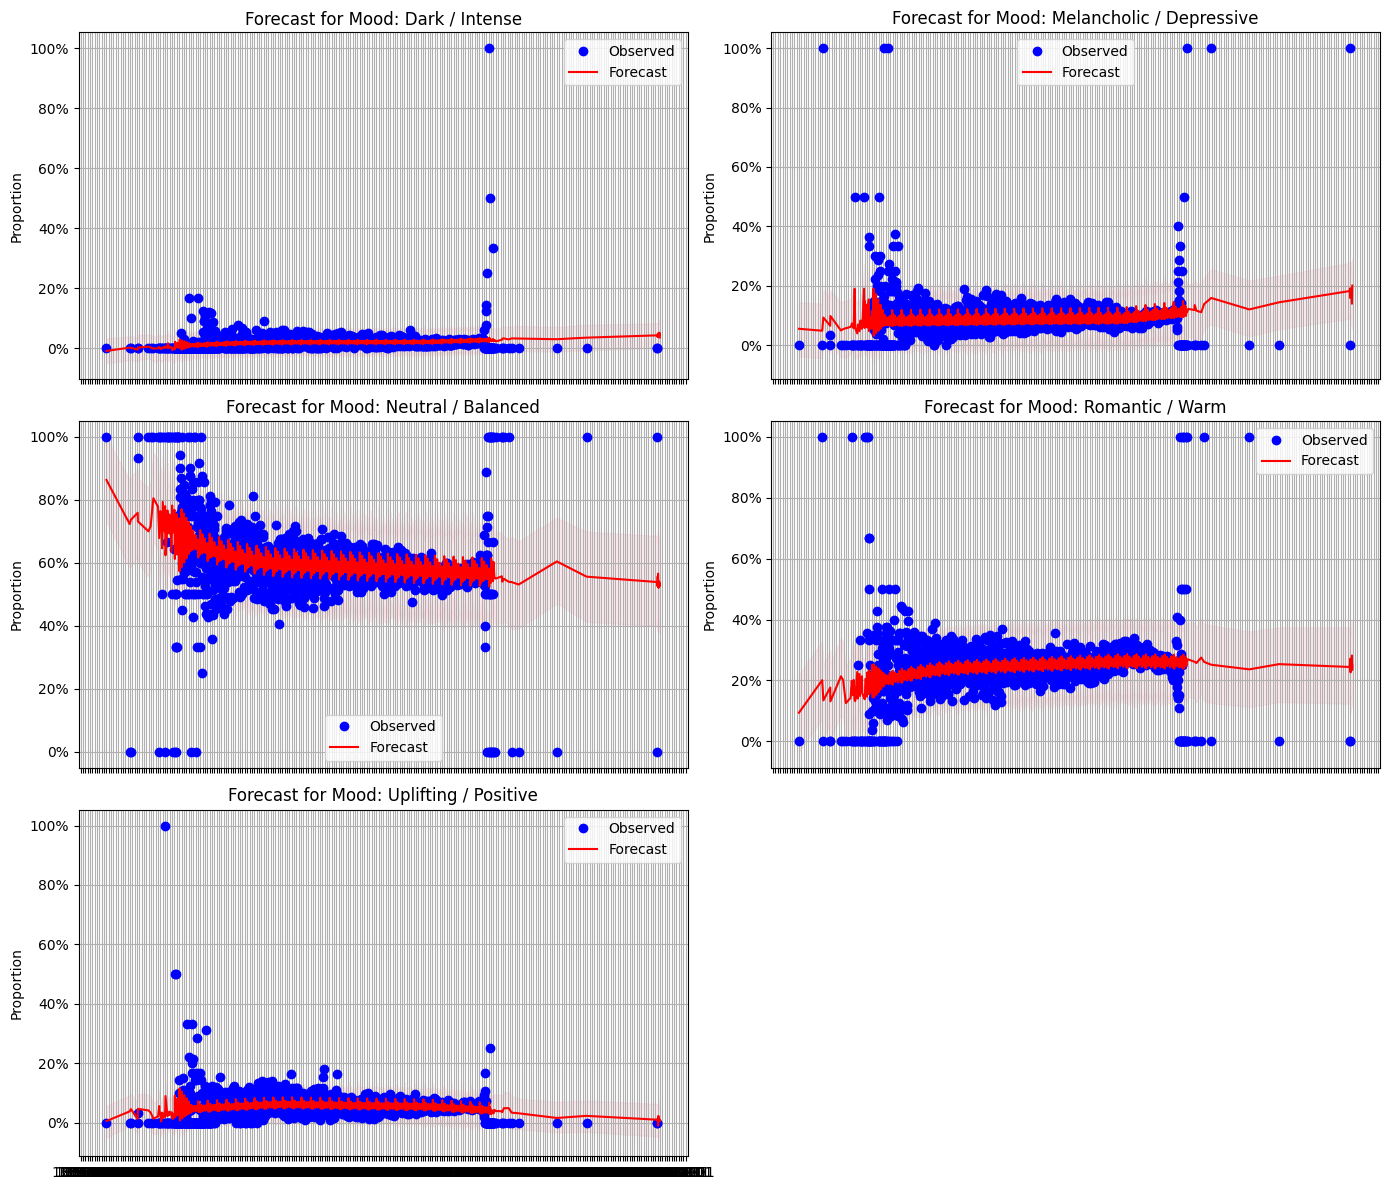

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume tmdb_encoded DataFrame is available

# Aggregate monthly mood proportions as before
tmdb_encoded['year_month'] = pd.to_datetime(tmdb_encoded['release_year'].astype(str) + '-' + tmdb_encoded['release_month'].astype(str) + '-01')
monthly_mood_counts = tmdb_encoded.groupby(['year_month', 'mood_category']).size().unstack(fill_value=0)
monthly_mood_props = monthly_mood_counts.div(monthly_mood_counts.sum(axis=1), axis=0).reset_index()

mood_categories = monthly_mood_props.columns.drop('year_month')

# Create subplots for each mood
num_moods = len(mood_categories)
cols = 2
rows = (num_moods + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()

for i, mood in enumerate(mood_categories):
    df = monthly_mood_props[['year_month', mood]].rename(columns={'year_month': 'ds', mood: 'y'})

    # Fit and forecast with Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)

    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    ax = axes[i]
    # Plot historical data points
    ax.plot(df['ds'], df['y'], 'o', label='Observed', color='blue')
    # Plot forecasted trend and uncertainty
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

    ax.set_title(f'Forecast for Mood: {mood}')
    ax.set_ylabel('Proportion')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format y-axis as percentage
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/wkvvg0yb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/xi5bsikh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27850', 'data', 'file=/tmp/tmpa6d9qifv/wkvvg0yb.json', 'init=/tmp/tmpa6d9qifv/xi5bsikh.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_modelfgeorbbw/prophet_model-20251031005838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


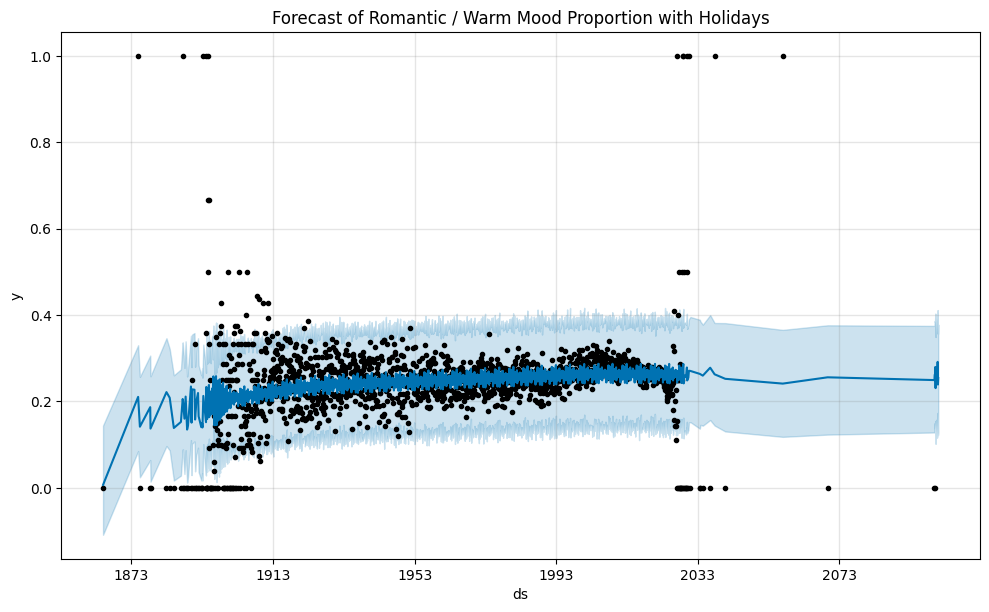

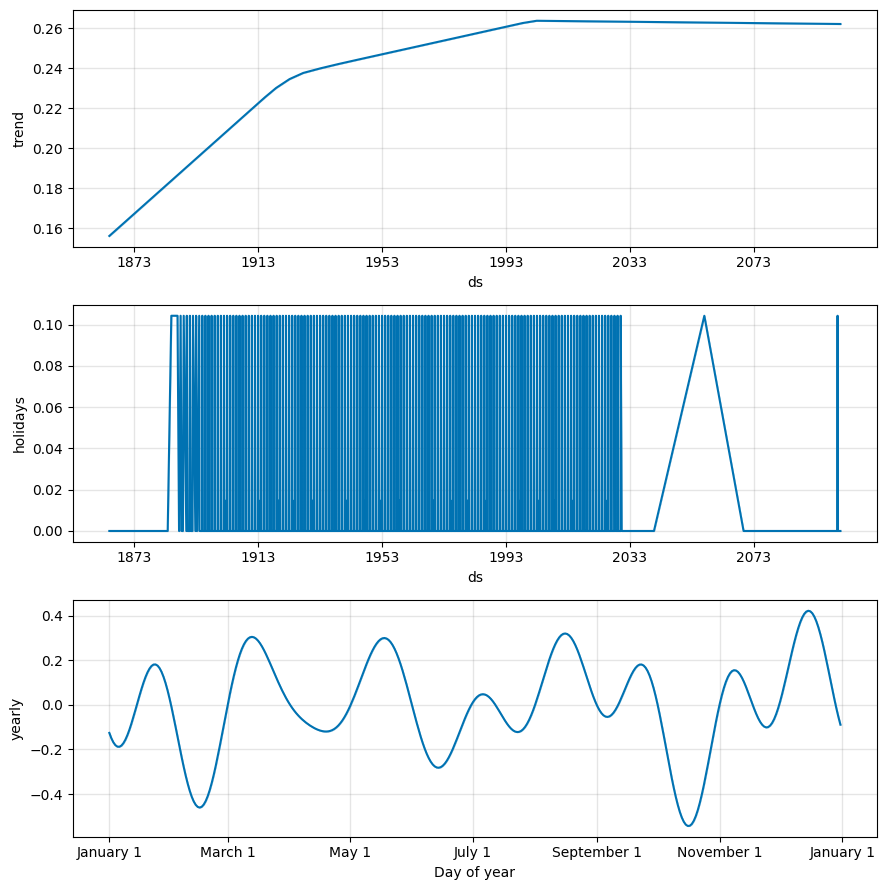

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare your monthly mood proportions example (for one mood)
mood_to_forecast = 'Romantic / Warm'
df_prophet = monthly_mood_props[['year_month', mood_to_forecast]].rename(columns={'year_month': 'ds', mood_to_forecast: 'y'})

# Define custom holidays relevant to your context, for example,
# major movie festivals or holidays when movie releases spike
holidays = pd.DataFrame({
    'holiday': 'movie_festival',
    'ds': pd.to_datetime(['2019-02-10', '2020-02-09', '2021-02-15']),  # Festival dates
    'lower_window': 0,
    'upper_window': 1
})

# Initialize Prophet with yearly seasonality and holidays
model = Prophet(yearly_seasonality=True, holidays=holidays)
# Add built-in country holidays, e.g., for US or India
model.add_country_holidays(country_name='US')

model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Plot forecast including holiday and seasonality components
model.plot(forecast)
plt.title(f"Forecast of {mood_to_forecast} Mood Proportion with Holidays")
plt.show()

model.plot_components(forecast)
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/nbtf2ssl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/afeqiug1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55436', 'data', 'file=/tmp/tmpa6d9qifv/nbtf2ssl.json', 'init=/tmp/tmpa6d9qifv/afeqiug1.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_modelpei8n198/prophet_model-20251031005958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:59:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:59:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


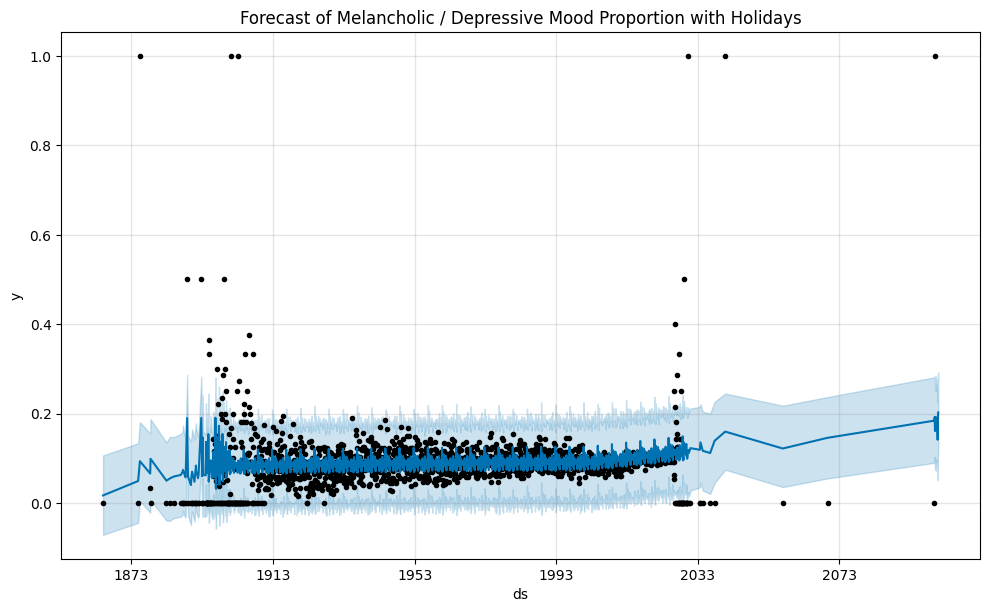

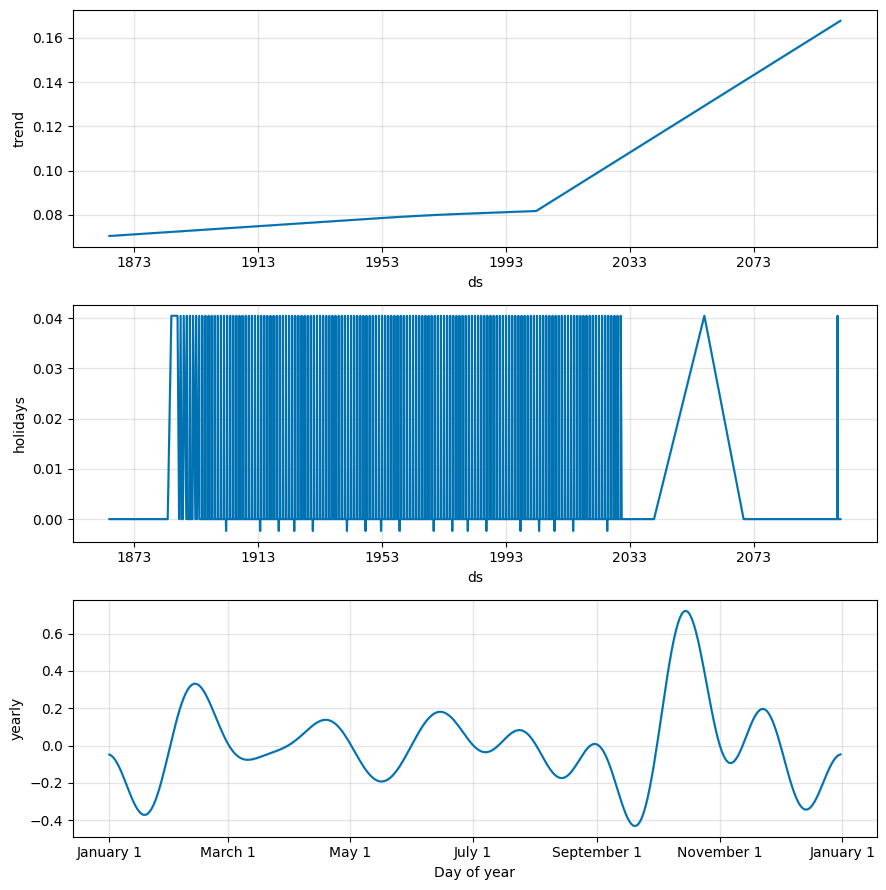

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare your monthly mood proportions example (for one mood)
mood_to_forecast = 'Melancholic / Depressive'
df_prophet = monthly_mood_props[['year_month', mood_to_forecast]].rename(columns={'year_month': 'ds', mood_to_forecast: 'y'})

# Define custom holidays relevant to your context, for example,
# major movie festivals or holidays when movie releases spike
holidays = pd.DataFrame({
    'holiday': 'movie_festival',
    'ds': pd.to_datetime(['2019-02-10', '2020-02-09', '2021-02-15']),  # Festival dates
    'lower_window': 0,
    'upper_window': 1
})

# Initialize Prophet with yearly seasonality and holidays
model = Prophet(yearly_seasonality=True, holidays=holidays)
# Add built-in country holidays, e.g., for US or India
model.add_country_holidays(country_name='US')

model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Plot forecast including holiday and seasonality components
model.plot(forecast)
plt.title(f"Forecast of {mood_to_forecast} Mood Proportion with Holidays")
plt.show()

model.plot_components(forecast)
plt.show()

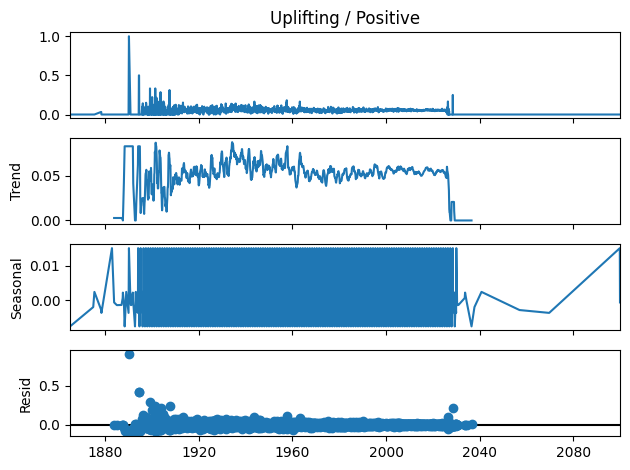

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume monthly_mood_props DataFrame as before, with 'year_month' and mood columns
mood = 'Uplifting / Positive'
ts = monthly_mood_props.set_index('year_month')[mood]

# Perform seasonal decomposition assuming additive model and monthly frequency (period=12)
result = seasonal_decompose(ts, model='additive', period=12)

# Plot observed, trend, seasonal, and residual components
result.plot()
# plt.suptitle(f'Time Series Decomposition of Mood: {mood}', fontsize=16)
plt.show()

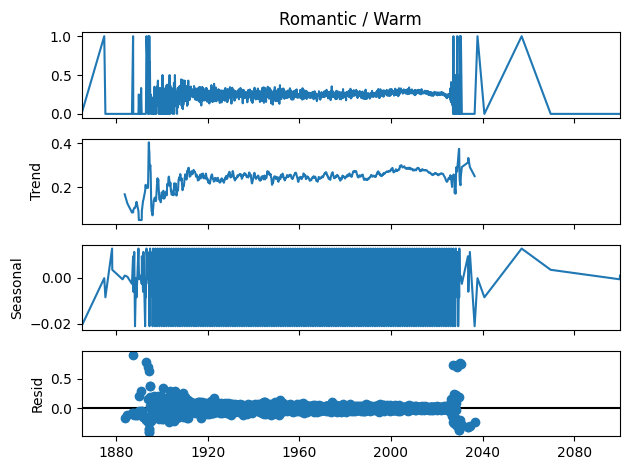

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume monthly_mood_props DataFrame as before, with 'year_month' and mood columns
mood = 'Romantic / Warm'
ts = monthly_mood_props.set_index('year_month')[mood]

# Perform seasonal decomposition assuming additive model and monthly frequency (period=12)
result = seasonal_decompose(ts, model='additive', period=12)

# Plot observed, trend, seasonal, and residual components
result.plot()
# plt.suptitle(f'Time Series Decomposition of Mood: {mood}', fontsize=16)
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/lkh2ug3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/i8px8bce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95679', 'data', 'file=/tmp/tmpa6d9qifv/lkh2ug3j.json', 'init=/tmp/tmpa6d9qifv/i8px8bce.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_modele3wr0syn/prophet_model-20251031010717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


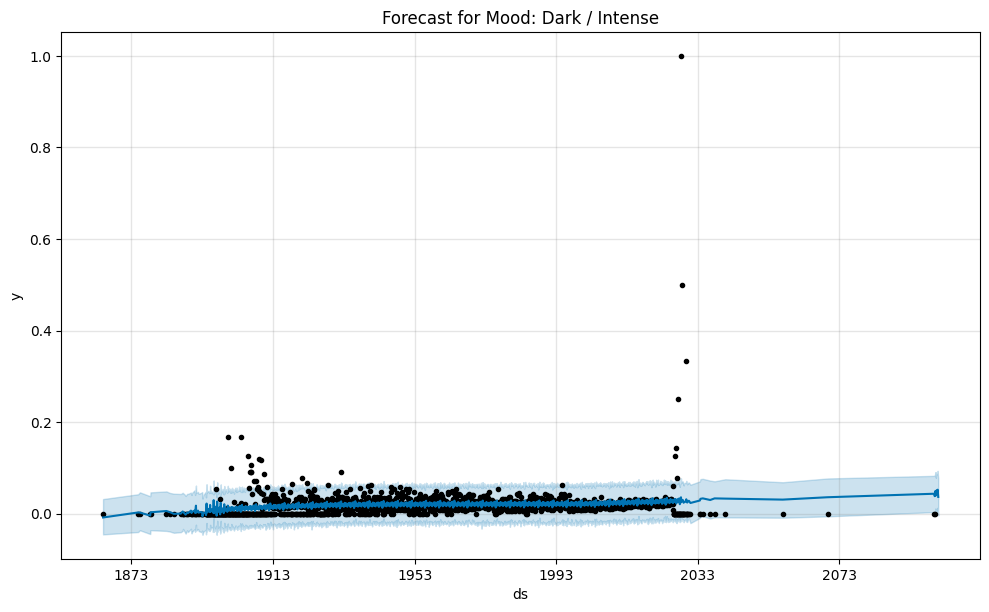

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/ce6nhes6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/y8rmvwac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54066', 'data', 'file=/tmp/tmpa6d9qifv/ce6nhes6.json', 'init=/tmp/tmpa6d9qifv/y8rmvwac.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_modelhc7fj8ol/prophet_model-20251031010717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


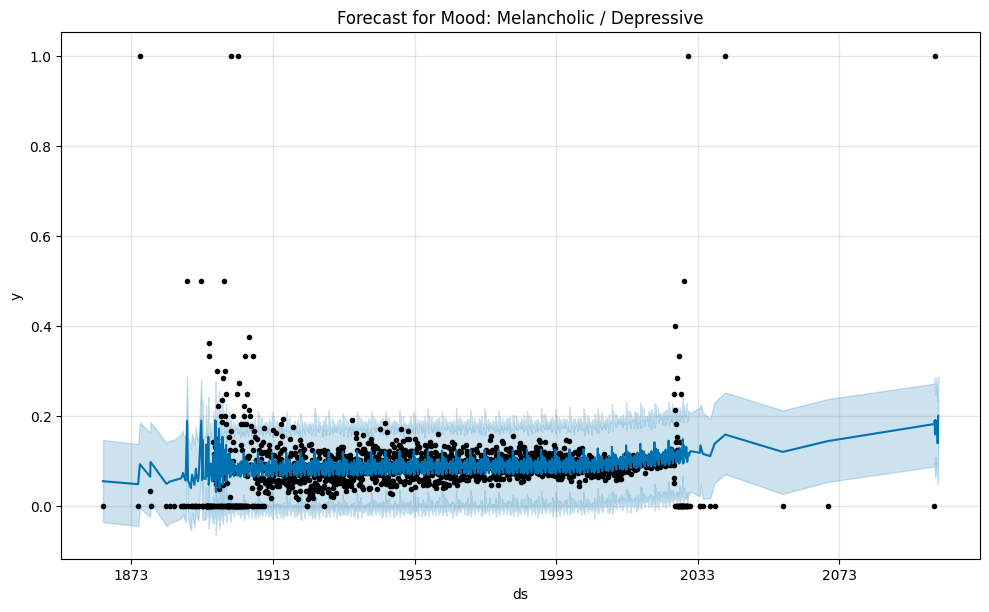

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/lb3uw9i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/f5lqz4e7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59630', 'data', 'file=/tmp/tmpa6d9qifv/lb3uw9i7.json', 'init=/tmp/tmpa6d9qifv/f5lqz4e7.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_model6v_va96f/prophet_model-20251031010718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


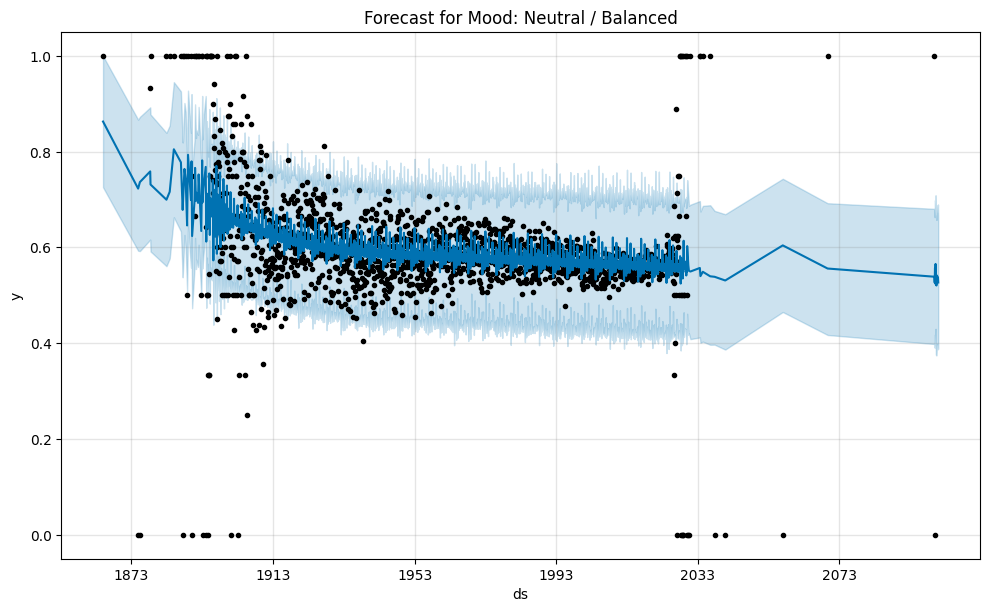

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/tp5nlm7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/x9iu3v74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32193', 'data', 'file=/tmp/tmpa6d9qifv/tp5nlm7_.json', 'init=/tmp/tmpa6d9qifv/x9iu3v74.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_modela5n8fefq/prophet_model-20251031010718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


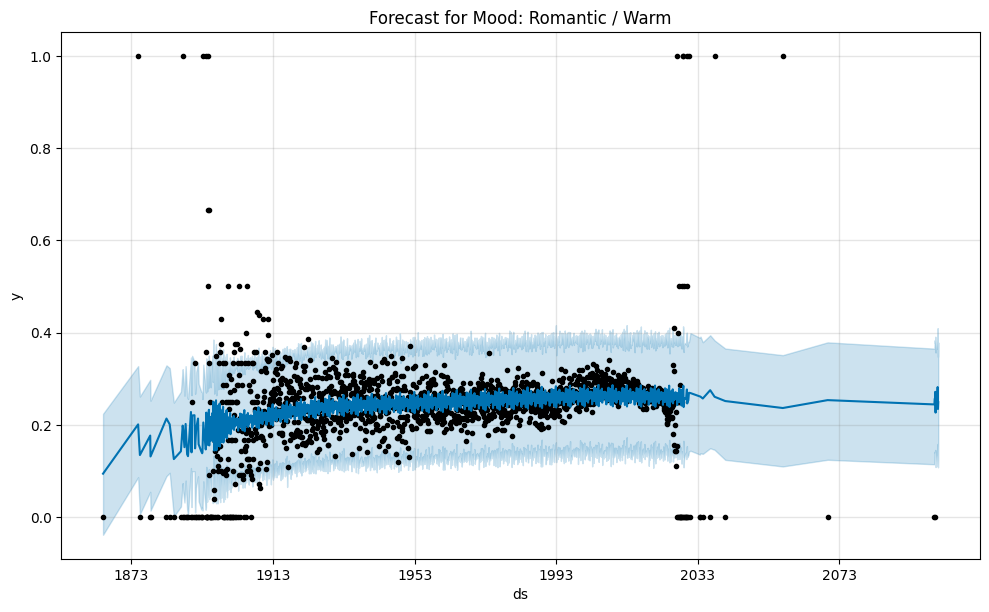

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/qlfslao6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa6d9qifv/ht1luffc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76395', 'data', 'file=/tmp/tmpa6d9qifv/qlfslao6.json', 'init=/tmp/tmpa6d9qifv/ht1luffc.json', 'output', 'file=/tmp/tmpa6d9qifv/prophet_modelshhsq002/prophet_model-20251031010719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


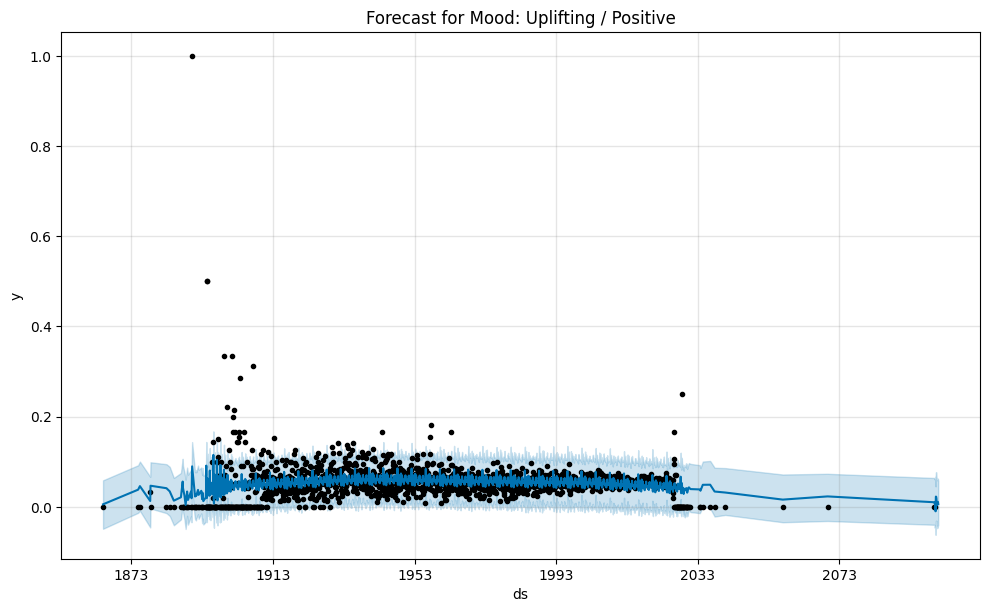

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assume monthly_mood_props is your DataFrame with 'year_month' and mood proportions columns
mood_categories = monthly_mood_props.columns.drop('year_month')

# Container to store forecasts
forecast_dict = {}

# Loop through all moods and create forecasts
for mood in mood_categories:
    df_prophet = monthly_mood_props[['year_month', mood]].rename(columns={'year_month': 'ds', mood: 'y'})

    model = Prophet(yearly_seasonality=True)
    model.fit(df_prophet)

    # Forecast next 12 months
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    # Store forecast dataframe keyed by mood
    forecast_dict[mood] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f'Forecast for Mood: {mood}')
    plt.show()

# Now forecast_dict contains future forecasts for all moods for further analysis or combined plotting

In [ ]:
## Testing Phase on SVC

In [ ]:
testing = pd.read_csv("testdata.csv")

In [ ]:
testing

,title,release_date,overview,tagline,keywords,genres,budget,popularity,vote_average,vote_count,mood_class
0,The Smashing Machine,2025-10-03,Follows MMA legend Mark Kerr as he rises to fa...,The cost of greatness.,"fight,struggle,fame,sports,drama","Action,Drama",80000000,85,7.9,250,Dark / Intense
1,After the Hunt,2025-10-10,A Yale professor faces professional and person...,Secrets never stay buried.,"university,tenure,secrets,Drama",Drama,20000000,65,7.3,143,Melancholic / Depressive
2,Ne Zha 2,2025-07-15,Animated epic continuing the adventures of the...,Fate returns.,"myth,fantasy","Animation,Adventure,Fantasy",50000000,140,8.1,2031,Uplifting / Positive
3,Lilo & Stitch,2025-06-18,Live-action remake of the story about friendsh...,Family is everything.,"friendship,island,family","Comedy,Adventure,Family",120000000,160,7.5,1932,Uplifting / Positive
4,A Minecraft Movie,2025-04-23,Adventurers must save their blocky world from ...,"Block by block, world saved.","adventure,game","Action,Adventure",110000000,120,7.0,1358,Uplifting / Positive
5,Jurassic World Rebirth,2025-05-09,Dinosaurs return in this new thrill-filled seq...,History is alive.,"dinosaurs,science","Action,Adventure,Sci-Fi",150000000,128,6.9,1750,Dark / Intense
6,Demon Slayer The Movie: Infinity Castle,2025-08-10,Final battle against evil demons inside a myst...,The ultimate demon slaying.,"demons,anime,action","Animation,Action,Fantasy,Anime",90000000,170,8.3,2219,Dark / Intense
7,How to Train Your Dragon,2025-07-29,New adventures for Hiccup and Toothless.,The legend returns.,"dragons,animation,fantasy","Animation,Family,Adventure",135000000,133,7.4,1286,Uplifting / Positive
8,F1,2025-06-30,Drama inside the high-stakes world of Formula ...,No room for second place.,"racing,sports,drama","Action,Drama",85000000,110,7.1,601,Dark / Intense
9,The Fantastic Four: First Steps,2025-10-30,Reboot as Marvel's iconic foursome face new co...,A new beginning.,"superhero,marvel,comic","Action,Adventure,Sci-Fi",210000000,174,7.2,891,Neutral / Balanced


In [ ]:
test_clean = testing.copy()
test_clean = test_clean.dropna(subset=['release_date', 'overview', 'genres', 'title'])
test_clean['release_date'] = pd.to_datetime(test_clean['release_date'], errors='coerce')
test_clean['release_year'] = test_clean['release_date'].dt.year
test_clean['release_month'] = test_clean['release_date'].dt.month

test_clean.drop(columns=['release_date'], inplace=True)

from textblob import TextBlob

def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

test_clean['overview_sentiment'] = test_clean['overview'].apply(get_sentiment)
test_clean['tagline_sentiment'] = test_clean['tagline'].apply(get_sentiment)

test_clean['overview_length'] = test_clean['overview'].fillna('').apply(len)
test_clean['tagline_length'] = test_clean['tagline'].fillna('').apply(len)

test_clean['composite_sentiment'] = (test_clean['overview_sentiment'] * 0.7 +
    test_clean['tagline_sentiment'] * 0.3
)

def classify_mood(score):
    if score > 0.3:
        return 'Uplifting / Positive'
    elif score > 0.1:
        return 'Romantic / Warm'
    elif score < -0.3:
        return 'Dark / Intense'
    elif score < -0.1:
        return 'Melancholic / Depressive'
    else:
        return 'Neutral / Balanced'

test_clean['mood_category'] = test_clean['composite_sentiment'].apply(classify_mood)

from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# 1️⃣ Ensure 'genres' column is clean and a list per row
test_clean['genres'] = test_clean['genres'].fillna('').apply(
    lambda x: [g.strip() for g in x.split(',') if g]
)

# 2️⃣ Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(test_clean['genres']),
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=test_clean.index   # ✅ Important: Keep same index
)

# 3️⃣ Concatenate safely
test_encoded = pd.concat([test_clean, genre_encoded], axis=1)

In [ ]:
test_encoded

,title,overview,tagline,keywords,genres,budget,popularity,vote_average,vote_count,mood_class,...,mood_category,genre_Action,genre_Adventure,genre_Animation,genre_Anime,genre_Comedy,genre_Drama,genre_Family,genre_Fantasy,genre_Sci-Fi
0,The Smashing Machine,Follows MMA legend Mark Kerr as he rises to fa...,The cost of greatness.,"fight,struggle,fame,sports,drama","[Action, Drama]",80000000,85,7.9,250,Dark / Intense,...,Neutral / Balanced,1,0,0,0,0,1,0,0,0
1,After the Hunt,A Yale professor faces professional and person...,Secrets never stay buried.,"university,tenure,secrets,Drama",[Drama],20000000,65,7.3,143,Melancholic / Depressive,...,Neutral / Balanced,0,0,0,0,0,1,0,0,0
2,Ne Zha 2,Animated epic continuing the adventures of the...,Fate returns.,"myth,fantasy","[Animation, Adventure, Fantasy]",50000000,140,8.1,2031,Uplifting / Positive,...,Neutral / Balanced,0,1,1,0,0,0,0,1,0
3,Lilo & Stitch,Live-action remake of the story about friendsh...,Family is everything.,"friendship,island,family","[Comedy, Adventure, Family]",120000000,160,7.5,1932,Uplifting / Positive,...,Neutral / Balanced,0,1,0,0,1,0,1,0,0
4,A Minecraft Movie,Adventurers must save their blocky world from ...,"Block by block, world saved.","adventure,game","[Action, Adventure]",110000000,120,7.0,1358,Uplifting / Positive,...,Neutral / Balanced,1,1,0,0,0,0,0,0,0
5,Jurassic World Rebirth,Dinosaurs return in this new thrill-filled seq...,History is alive.,"dinosaurs,science","[Action, Adventure, Sci-Fi]",150000000,128,6.9,1750,Dark / Intense,...,Romantic / Warm,1,1,0,0,0,0,0,0,1
6,Demon Slayer The Movie: Infinity Castle,Final battle against evil demons inside a myst...,The ultimate demon slaying.,"demons,anime,action","[Animation, Action, Fantasy, Anime]",90000000,170,8.3,2219,Dark / Intense,...,Melancholic / Depressive,1,0,1,1,0,0,0,1,0
7,How to Train Your Dragon,New adventures for Hiccup and Toothless.,The legend returns.,"dragons,animation,fantasy","[Animation, Family, Adventure]",135000000,133,7.4,1286,Uplifting / Positive,...,Neutral / Balanced,0,1,1,0,0,0,1,0,0
8,F1,Drama inside the high-stakes world of Formula ...,No room for second place.,"racing,sports,drama","[Action, Drama]",85000000,110,7.1,601,Dark / Intense,...,Neutral / Balanced,1,0,0,0,0,1,0,0,0
9,The Fantastic Four: First Steps,Reboot as Marvel's iconic foursome face new co...,A new beginning.,"superhero,marvel,comic","[Action, Adventure, Sci-Fi]",210000000,174,7.2,891,Neutral / Balanced,...,Romantic / Warm,1,1,0,0,0,0,0,0,1


In [ ]:
test_encoded.columns.tolist()

['title',
 'overview',
 'tagline',
 'keywords',
 'genres',
 'budget',
 'popularity',
 'vote_average',
 'vote_count',
 'mood_class',
 'release_year',
 'release_month',
 'overview_sentiment',
 'tagline_sentiment',
 'overview_length',
 'tagline_length',
 'composite_sentiment',
 'mood_category',
 'genre_Action',
 'genre_Adventure',
 'genre_Animation',
 'genre_Anime',
 'genre_Comedy',
 'genre_Drama',
 'genre_Family',
 'genre_Fantasy',
 'genre_Sci-Fi']

In [ ]:
features = [
    'budget', 'popularity', 'vote_average', 'vote_count',
    'overview_length', 'tagline_length',
    'overview_sentiment', 'tagline_sentiment', 'composite_sentiment',
    'release_year', 'release_month'
] + [col for col in test_encoded.columns if col.startswith('genre_')]

In [ ]:
test_df = test_encoded[features]

In [ ]:
test_df.columns.tolist()

['budget',
 'popularity',
 'vote_average',
 'vote_count',
 'overview_length',
 'tagline_length',
 'overview_sentiment',
 'tagline_sentiment',
 'composite_sentiment',
 'release_year',
 'release_month',
 'genre_Action',
 'genre_Adventure',
 'genre_Animation',
 'genre_Anime',
 'genre_Comedy',
 'genre_Drama',
 'genre_Family',
 'genre_Fantasy',
 'genre_Sci-Fi']

In [ ]:
# Step 1: Create a copy of test_df to avoid altering original
test_fixed = test_df.copy()

# Step 2: Ensure all training columns are present
for col in X_train.columns:
    if col not in test_fixed.columns:
        test_fixed[col] = 0  # add missing columns as zeros

# Step 3: Reorder columns to match training data
test_fixed = test_fixed[X_train.columns]

In [ ]:
test_fixed

,budget,popularity,vote_average,vote_count,overview_length,tagline_length,overview_sentiment,tagline_sentiment,composite_sentiment,release_year,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western
0,80000000,85,7.9,250,91,22,0.100000,0.000000,0.070000,2025,...,0,0,0,0,0,0,0,0,0,0
1,20000000,65,7.3,143,78,26,0.050000,0.000000,0.035000,2025,...,0,0,0,0,0,0,0,0,0,0
2,50000000,140,8.1,2031,72,13,0.100000,0.000000,0.070000,2025,...,0,0,0,0,0,0,0,0,0,0
3,120000000,160,7.5,1932,83,21,-0.075000,0.000000,-0.052500,2025,...,0,0,0,0,0,0,0,0,0,0
4,110000000,120,7.0,1358,58,28,0.000000,0.000000,0.000000,2025,...,0,0,0,0,0,0,0,0,0,0
5,150000000,128,6.9,1750,50,17,0.136364,0.100000,0.125455,2025,...,0,0,0,0,0,0,0,0,0,0
6,90000000,170,8.3,2219,60,27,-0.333333,0.000000,-0.233333,2025,...,0,0,0,0,0,0,0,0,0,0
7,135000000,133,7.4,1286,40,19,0.136364,0.000000,0.095455,2025,...,0,0,0,0,0,0,0,0,0,0
8,85000000,110,7.1,601,55,25,0.000000,0.000000,0.000000,2025,...,0,0,0,0,0,0,0,0,0,0
9,210000000,174,7.2,891,62,16,0.318182,0.136364,0.263636,2025,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test_scaled_final = scaler.transform(test_fixed)

In [ ]:
y_pred_svc = svc.predict(X_test_scaled_final)

In [ ]:
y_pred_svc

array(['Neutral / Balanced', 'Neutral / Balanced', 'Neutral / Balanced',
       'Neutral / Balanced', 'Neutral / Balanced', 'Neutral / Balanced',
       'Neutral / Balanced', 'Romantic / Warm', 'Neutral / Balanced',
       'Neutral / Balanced'], dtype=object)

In [ ]:
y_pred_xgb = xgb.predict(X_test_scaled_final)

In [ ]:
y_pred_xgb

array([3, 2, 3, 0, 1, 4, 0, 4, 1, 4])

In [ ]:
y_pred_xgb_label = le.inverse_transform(y_pred_xgb)

In [ ]:
y_pred_xgb_label

array(['Romantic / Warm', 'Neutral / Balanced', 'Romantic / Warm',
       'Dark / Intense', 'Melancholic / Depressive',
       'Uplifting / Positive', 'Dark / Intense', 'Uplifting / Positive',
       'Melancholic / Depressive', 'Uplifting / Positive'], dtype=object)

In [ ]:
y_pred_rfff = rf.predict(X_test_scaled_final)
y_pred_rfff

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['Romantic / Warm', 'Neutral / Balanced', 'Romantic / Warm',
       'Dark / Intense', 'Melancholic / Depressive',
       'Uplifting / Positive', 'Dark / Intense', 'Uplifting / Positive',
       'Melancholic / Depressive', 'Uplifting / Positive'], dtype=object)

In [ ]:
y_pred_logg = log_reg.predict(X_test_scaled_final)
y_pred_logg

array(['Neutral / Balanced', 'Neutral / Balanced', 'Neutral / Balanced',
       'Neutral / Balanced', 'Neutral / Balanced', 'Romantic / Warm',
       'Melancholic / Depressive', 'Neutral / Balanced',
       'Neutral / Balanced', 'Romantic / Warm'], dtype=object)